    # Output CN plot

In [5]:
import matplotlib
import matplotlib.pyplot as plt
# imports
import json
import scgenome.plotting as pl
import h5py
import anndata
import numpy as np

In [6]:
import os
print(os.getcwd())


/Users/haraldme/git/Lagergren Lab/CopyTree/VICTree/victree/src/experiments


In [9]:
# read output h5
# out_file = h5py.File('/Users/zemp/phd/scilife/cpt_experiments/output/spectr006/out_k6a7n1314m6206.h5') # 006
#out_file = h5py.File('../../output/P01-066/K6L100i200s0p1/victree.out.h5ad') # 014
base_path = "../../tests/test_output/experiments/fixed_tree_experiments/VICtreeFixedTreeExperiment/fixed_tree_real_data_experiment"
hyper_params = "K8_A7_rho0.3_niter100_SVI0_mixed_split2"
prior_params = "lambda050000_alpha500.0_beta50.0_delta3.0"
experiment_seed = "seed_0"
path = os.path.join(base_path, hyper_params)
path = os.path.join(path, prior_params)
path = os.path.join(path, experiment_seed)

out_file = anndata.read_h5ad(os.path.join(path, 'victree.out.h5ad')) # 014
model_file = h5py.File(os.path.join(path, 'victree.model.h5')) # 014
with open(os.path.join(path, "victree.config.json")) as file:
    config_file = json.load(file)

print(f'out file keys: {out_file}')
print(f'model file keys: {model_file.keys()}')
print(f'config keys: {config_file}')

out file keys: AnnData object with n_obs × n_vars = 683 × 6206
    obs: 'victree-mu', 'victree-mt-lambda', 'victree-mt-alpha', 'victree-mt-beta', 'victree-tau', 'victree-clone', 'victree-loglik'
    var: 'bin', 'chr', 'start', 'end'
    uns: 'victree-eps-alpha', 'victree-eps-beta', 'victree-tree-newick'
    obsm: 'victree-clone-probs'
    varm: 'victree-cn-pprobs', 'victree-cn-sprobs'
    layers: 'victree-cn-marginal', 'victree-cn-viterbi'
model file keys: <KeysViewHDF5 ['FixedTreeJointDist', 'qC', 'qEpsilonMulti', 'qMuTau', 'qPi', 'qZ']>
config keys: {'step_size_delay': 1.0, 'step_size_forgetting_rate': 0.5, 'step_size_scheme': 'None', 'batch_size': 50, 'SVI': False, 'split': 'mixed', 'curr_it': 100, 'qc_smoothing': False, '_diagnostics': False, 'step_size': 0.3, 'annealing': 1.0, '_n_nodes': 8, '_n_states': 7, '_eps0': 0.01, '_n_cells': 683, '_chain_length': 6206, '_n_chromosomes': 24, '_chromosome_indexes': [499, 986, 1383, 1766, 2128, 2471, 2790, 3083, 3366, 3638, 3909, 4177, 4408,

/Users/haraldme/miniconda3/envs/victree/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
print(out_file.layers.keys())
print(out_file.obs.keys())

KeysView(Layers with keys: victree-cn-marginal, victree-cn-viterbi)
Index(['victree-mu', 'victree-mt-lambda', 'victree-mt-alpha',
       'victree-mt-beta', 'victree-tau', 'victree-clone', 'victree-loglik'],
      dtype='object')


In [11]:
# get cell assignment and cell copy number
top_z = out_file.obsm['victree-clone-probs'][...].argmax(axis=1)
clone_cn_np = out_file.layers['victree-cn-marginal'][...].argmax(axis=-1)
cell_cn = clone_cn_np[top_z, :]

In [18]:
from utils import factory_utils

qC = factory_utils.construct_qCMultiChrome_from_model_output_data(model_file)
qC.compute_filtering_probs()
print(qC.single_filtering_probs[1, 0:3])

ValueError: too many values to unpack (expected 3)

In [13]:
# create anndata
# adata = anndata.read_h5ad('/Users/zemp/Downloads/data/signals_SPECTRUM-OV-006.h5')
adata = anndata.read_h5ad('../../data/x_data/P01-066_cn_data.h5ad')
# adata = anndata.read_h5ad('/Users/zemp/Downloads/data/signals_SPECTRUM-OV-107.h5')


adata.obs['clone'] = top_z

In [14]:
print(cell_cn.shape)
print(clone_cn_np.shape)

(683, 6206)
(683, 6206)


In [17]:
from utils import visualization_utils
import torch
matplotlib.use('Qt5Agg')
K = qC.config.n_nodes
qC_marginals_np = qC.single_filtering_probs.numpy()
qC_viterbi = qC.get_viterbi()
viterbi_distances = torch.zeros(K, K)

for i in range(0, K):
    for j in range(i+1, K):
        viterbi_distances[i, j] = torch.abs((qC_viterbi[i] - qC_viterbi[j]).sum())

NameError: name 'qC' is not defined

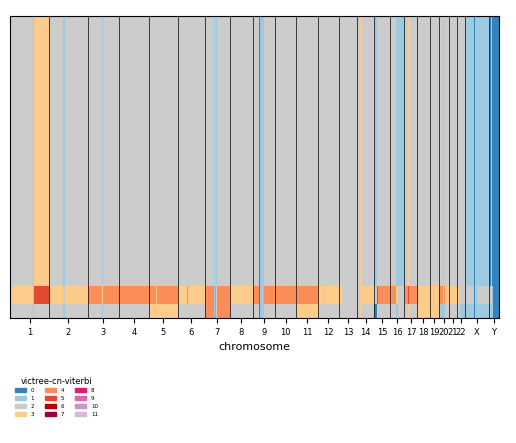

In [16]:
%matplotlib inline
#out_file.layers['victree-cn-marginal'] = cell_qc.get_viterbi()[1:].numpy()
g = pl.plot_cell_cn_matrix_fig(out_file, 'victree-cn-viterbi', cell_order_fields=['victree-clone'], max_cn=7)

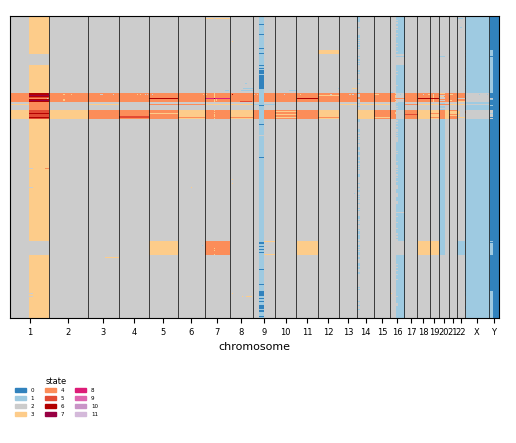

In [52]:
adata.obs['victree-clone'] = out_file.obs['victree-clone']
g = pl.plot_cell_cn_matrix_fig(adata, 'state', cell_order_fields=['clone'])

In [54]:
adata.obs_keys()

['multiplier',
 'MSRSI_non_integerness',
 'MBRSI_dispersion_non_integerness',
 'MBRSM_dispersion',
 'autocorrelation_hmmcopy',
 'cv_hmmcopy',
 'empty_bins_hmmcopy',
 'mad_hmmcopy',
 'mean_hmmcopy_reads_per_bin',
 'median_hmmcopy_reads_per_bin',
 'std_hmmcopy_reads_per_bin',
 'total_mapped_reads_hmmcopy',
 'total_halfiness',
 'scaled_halfiness',
 'mean_state_mads',
 'mean_state_vars',
 'mad_neutral_state',
 'breakpoints',
 'mean_copy',
 'state_mode',
 'log_likelihood',
 'true_multiplier',
 'percent_duplicate_reads',
 'standard_deviation_insert_size',
 'sample_type',
 'overlap_with_all_filters',
 'unpaired_duplicate_reads',
 'fastqscreen_salmon_multihit',
 'index_i5',
 'unpaired_mapped_reads',
 'fastqscreen_mouse',
 'pick_met',
 'index_i7',
 'mean_insert_size',
 'fastqscreen_salmon',
 'library_id',
 'index_sequence',
 'estimated_library_size',
 'coverage_depth',
 'is_contaminated',
 'fastqscreen_mouse_multihit',
 'total_reads',
 'column',
 'total_properly_paired',
 'median_insert_size',


<Axes: xlabel='chromosome'>

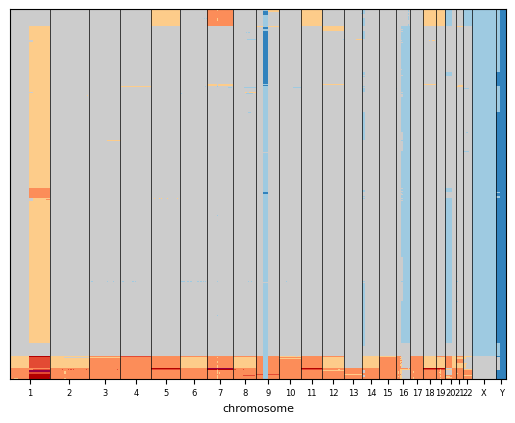

In [55]:
# sort cells based on cluster assignment
pl.plot_cell_cn_matrix(adata, 'state', cell_order_fields=['clustering_order'], max_cn=7)['ax']

In [96]:
import numpy as np
np.unique(top_z, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 8, 9]),
 array([165, 174, 108,  25, 138,  20,  22,  31]))

In [97]:
out_file['result']['trees'].keys()

KeyError: 'result'

In [98]:

for t in zip(out_file['result']['trees']['newick'], out_file['result']['trees']['weight']):
    print(t[0])
    print(t[1])
    print('---')

KeyError: 'result'